# Active Learning

In [1]:
%pip install modAL-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 4.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.ensemble import RandomForestClassifier

learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling
)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("genre_annotated_combination.csv")
print(data.iloc[24:27])


                artist                    song  year  popularity country  \
24  Scouting For Girls  This Ain't a Love Song  2017          52     USA   
25               KALEO          Way down We Go  2015          63     USA   
26            Tim3bomb              La Cancion  2017          65  Russia   

    danceability  
24         0.458  
25         0.590  
26         0.650  


In [11]:
X = data[['artist', 'song', 'year', 'popularity', 'country']]
y = data[['danceability']]

In [37]:
from sklearn.preprocessing import LabelEncoder

def encode_dataframe(df):
    """Encodes object-type columns using LabelEncoder."""
    encoders = {}
    for col in df.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

X = data.drop(columns=['country']).copy()
y = data[['year']].copy()

X, encoders_X = encode_dataframe(X)
y, encoders_y = encode_dataframe(y)

X = X.values
y = y.values.ravel()


In [38]:
def pick_highest_uncertainty(estimator, X_pool):
    """Return index of sample with largest predictive uncertainty."""
    _, sigma = estimator.predict(X_pool, return_std=True)
    return np.argmax(sigma)

In [39]:
from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# pick initial training set
n_init = 8
init_idx = np.random.choice(len(X), size=n_init, replace=False)

X_train, y_train = X[init_idx], y[init_idx]

kernel = 1.0 * RBF(length_scale=1.5, length_scale_bounds=(1e-3, 1e3)) \
       + WhiteKernel(noise_level=0.5, noise_level_bounds=(1e-5, 1e1))

learner = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel, normalize_y=True),
    query_strategy=pick_highest_uncertainty,
    X_training=X_train, y_training=y_train
)

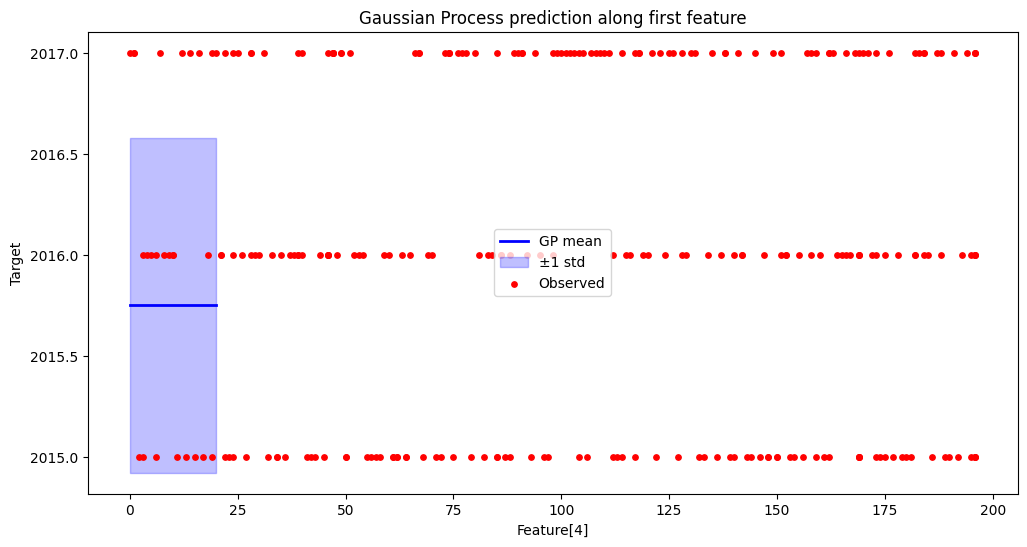

In [43]:
x_axis = np.linspace(0, 20, 500)

mean_X = np.mean(X, axis=0)
X_pred = np.tile(mean_X, (len(x_axis), 1))
X_pred[:, 0] = x_axis  # vary first feature

mean_pred, std_pred = learner.predict(X_pred, return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, mean_pred, color='blue', lw=2, label="GP mean")
plt.fill_between(x_axis,
                 mean_pred - std_pred,
                 mean_pred + std_pred,
                 alpha=0.25, color='blue', label="±1 std")
plt.scatter(X[:, 0], y, c='red', s=15, label="Observed")
plt.title("Gaussian Process prediction along first feature")
plt.xlabel("Feature[4]")
plt.ylabel("Target")
plt.legend()
plt.show()


# Active Learning Loop

In [41]:
n_rounds = 12
for _ in range(n_rounds):
    query_idx, query_sample = learner.query(X)
    learner.teach(X[query_idx].reshape(1, -1), y[query_idx].reshape(1,))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

# Visualization after AL

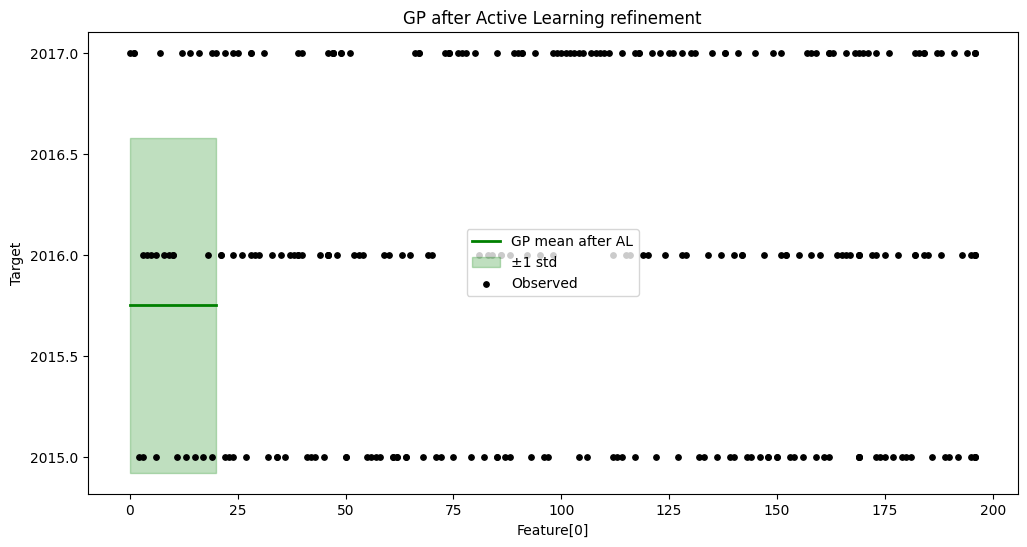

In [42]:
x_axis_new = np.linspace(0, 20, 500)
X_pred2 = np.zeros((len(x_axis_new), X.shape[1]))
X_pred2[:, 0] = x_axis_new

mean_pred2, std_pred2 = learner.predict(X_pred2, return_std=True)

plt.figure(figsize=(12, 6))
plt.plot(x_axis_new, mean_pred2, color='green', lw=2, label="GP mean after AL")
plt.fill_between(x_axis_new,
                 mean_pred2 - std_pred2,
                 mean_pred2 + std_pred2,
                 alpha=0.25, color='green', label="±1 std")
plt.scatter(X[:, 0], y, c='black', s=15, label="Observed")
plt.title("GP after Active Learning refinement")
plt.xlabel("Feature[0]")
plt.ylabel("Target")
plt.legend()
plt.show()

# Multimodal

In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

data = pd.read_csv("genre_annotated_combination.csv")

# Target
y = data["danceability"]

# Features
X = data[["artist", "song", "year", "popularity", "country"]].copy()

# Fill missing values
X["artist"] = X["artist"].fillna("unknown")
X["song"] = X["song"].fillna("unknown")
X["country"] = X["country"].fillna("unknown")



In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Numeric features
numeric_features = ['year', 'popularity']
numeric_transformer = StandardScaler()

# Text features (artist + song title → merged into one field)
data['text'] = data['artist'] + " " + data['song']
text_features = 'text'
text_transformer = TfidfVectorizer(max_features=200)

# Categorical features
categorical_features = ['country']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


# Transfer

In [70]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("txt", text_transformer, text_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [73]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


data = pd.read_csv("genre_annotated_combination.csv")
y = data["danceability"]
X = data[["artist", "song", "year", "popularity", "country"]].copy()


X["artist"] = X["artist"].fillna("unknown")
X["song"] = X["song"].fillna("unknown")
X["country"] = X["country"].fillna("unknown")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


preprocessor = ColumnTransformer(
    transformers=[
        ("artist_txt", TfidfVectorizer(max_features=100), "artist"),
        ("song_txt", TfidfVectorizer(max_features=100), "song"),
        ("country_cat", OneHotEncoder(handle_unknown="ignore"), ["country"]),
        ("num", StandardScaler(), ["year", "popularity"])
    ]
)

# preprocessing + regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", Ridge(alpha=1.0))
])

# Train
pipeline.fit(X_train, y_train)

# Predict + evaluate
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)


MSE: 0.013302338733152896


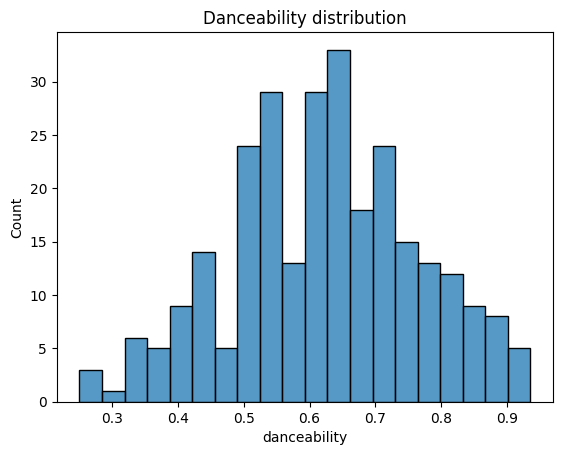

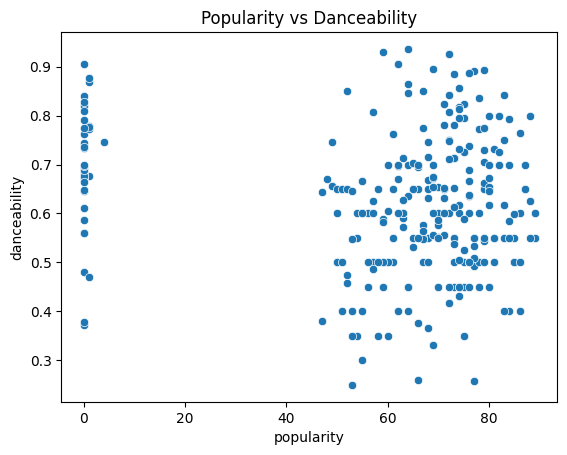

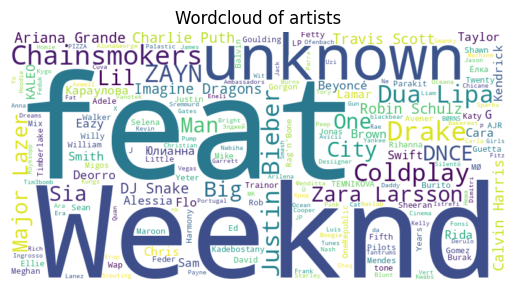

In [78]:


sns.histplot(data['danceability'], bins=20)
plt.title("Danceability distribution")
plt.show()

sns.scatterplot(x='popularity', y='danceability', data=data)
plt.title("Popularity vs Danceability")
plt.show()
from wordcloud import WordCloud

text = " ".join(data['artist'].fillna("unknown").tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of artists")
plt.show()


# Кеисы

Музыкальные платформы, такие как Яндекс, spotify, могут использовать эти мультимодальные наборы данных, чтобы рекомендовать песни пользователям.Он объединяет звуковые характеристики, тексты песен, метаданные исполнителя, изображения обложек альбомов, целевую аудиторию и год выпуска, чтобы понять сходство песен.Система может предсказать, какие новые песни, скорее всего, будут популярны или будут соответствовать настроению слушателя.Она может автоматически классифицировать песни по жанрам или создавать плейлисты, основанные на настроении.Такой подход помогает персонализировать работу пользователей, открывать для себя новую музыку и анализировать тенденции в музыкальной индустрии.